In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/bishoy/Fourth Year/Second Semester/Satellite Imagery/SI_Project/dataset2/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)


Device:  cuda:0


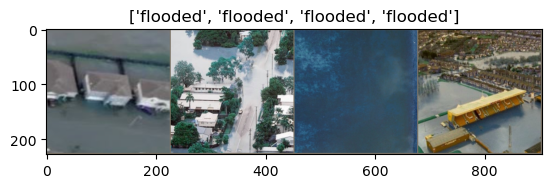

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5869 Acc: 0.7523
validation Loss: 0.5504 Acc: 0.8315

Epoch 1/24
----------
train Loss: 0.4897 Acc: 0.8363
validation Loss: 0.2563 Acc: 0.8859

Epoch 2/24
----------
train Loss: 0.5710 Acc: 0.8138
validation Loss: 0.0568 Acc: 0.9891

Epoch 3/24
----------
train Loss: 0.4210 Acc: 0.8483
validation Loss: 0.0870 Acc: 0.9783

Epoch 4/24
----------
train Loss: 0.3720 Acc: 0.8574
validation Loss: 0.0921 Acc: 0.9620

Epoch 5/24
----------
train Loss: 0.4397 Acc: 0.8363
validation Loss: 0.2109 Acc: 0.8913

Epoch 6/24
----------
train Loss: 0.4656 Acc: 0.8529
validation Loss: 0.1569 Acc: 0.9457

Epoch 7/24
----------
train Loss: 0.2532 Acc: 0.9009
validation Loss: 0.0805 Acc: 0.9620

Epoch 8/24
----------
train Loss: 0.2707 Acc: 0.9039
validation Loss: 0.0749 Acc: 0.9728

Epoch 9/24
----------
train Loss: 0.2645 Acc: 0.8949
validation Loss: 0.0681 Acc: 0.9783

Epoch 10/24
----------
train Loss: 0.2662 Acc: 0.8904
validation Loss: 0.0888 Acc: 0.9728

Epoch 11/

In [8]:
# save the model
saved_model_path = '/home/bishoy/Fourth Year/Second Semester/Satellite Imagery/SI_Project/ResNet18_test.pt'
torch.save(model_ft.state_dict(), saved_model_path)


In [9]:
# load the model
loaded_model_path = '/home/bishoy/Fourth Year/Second Semester/Satellite Imagery/SI_Project/ResNet18_test.pt'
loaded_model = models.resnet18(weights='IMAGENET1K_V1')
load_num_ftrs = loaded_model.fc.in_features
print(type(loaded_model))
# Here the size of each output sample is set to 2.
loaded_model.fc = nn.Linear(load_num_ftrs, 2)

loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load(loaded_model_path))


<class 'torchvision.models.resnet.ResNet'>


<All keys matched successfully>

In [12]:
# create a test dataset
test_dir = '/home/bishoy/Fourth Year/Second Semester/Satellite Imagery/SI_Project/dataset2/validation'
test_dataset = datasets.ImageFolder(
    test_dir, transform=data_transforms['validation'])
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=4)


In [13]:
# test the model on the test set
loaded_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for test_data in test_dataloader:
        images, labels = test_data
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the {total} test images: {100 * correct / total}%')


Accuracy of the network on the 184 test images: 98.91304347826087%
